In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.inspection import inspect
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [20]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)




In [21]:
# View all of the classes that automap found
Base.classes.keys()



['measurement', 'station']

In [22]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [24]:
# Find the most recent date in the data set.
Recent_Date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
Recent_Date = dt.date.fromisoformat(Recent_Date_str)
Recent_Date





datetime.date(2017, 8, 23)

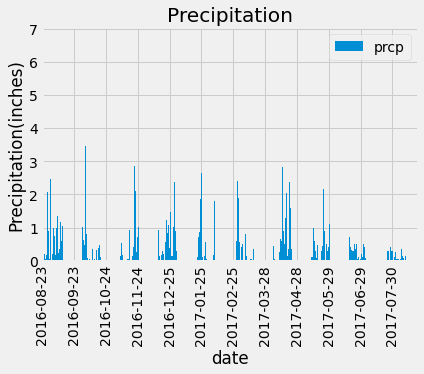

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

Prev_Recent_Date = dt.date(Recent_Date.year-1,Recent_Date.month,Recent_Date.day)
Prev_Recent_Date
# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Recent_Date)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_frame = pd.DataFrame(data_prcp, columns=['date', 'prcp'])
data_frame.set_index('date', inplace=True)
# Sort the dataframe by date
data_frame.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
data_frame.plot.bar()
#plt.tight_layout()
plt.xticks(rotation = 90)
plt.title("Precipitation")
plt.ylabel("Precipitation(inches)")
plt.locator_params(axis='x',nbins=12)
plt.show()


In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_data = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Recent_Date)).\
    order_by(Measurement.date).all()

prcp_data_frame = pd.DataFrame(query_data, columns=['date', 'prcp'])
prcp_data_frame.set_index('date', inplace=True)
prcp_data_frame
data_prcp_max = prcp_data_frame.groupby(["date"]).max()["prcp"] 
data_prcp_min = prcp_data_frame.groupby(["date"]).min()["prcp"] 
data_prcp_sum = prcp_data_frame.groupby(["date"]).sum()["prcp"] 
data_prcp_count = prcp_data_frame.groupby(["date"]).count()["prcp"] 

dict_data_prcp = {"Max": data_prcp_max
                 ,"Min":data_prcp_min
                 ,"Sum":data_prcp_sum
                 ,"Count":data_prcp_count 
                }

prcp_data_frame_summary = pd.DataFrame(dict_data_prcp)
prcp_data_frame_summary



,Max,Min,Sum,Count
date,,,,
2016-08-23,1.79,0.00,2.71,6
2016-08-24,2.28,0.08,9.33,6
2016-08-25,0.21,0.00,0.54,7
2016-08-26,0.04,0.00,0.10,6
2016-08-27,0.18,0.00,0.32,5
...,...,...,...,...
2017-08-19,0.09,0.00,0.09,3
2017-08-20,0.01,0.00,0.01,2
2017-08-21,0.56,0.00,0.58,3


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.station).count()
total_stations

9

In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(
        Measurement.station,
        func.count(Measurement.station)
    ).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

all_most_total_stations = most_active_stations.all()
all_most_total_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations.first()[0]
most_active_station_id
temp_summ = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    ).\
    filter(Measurement.station == most_active_station_id).all()

temp_summ

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:>

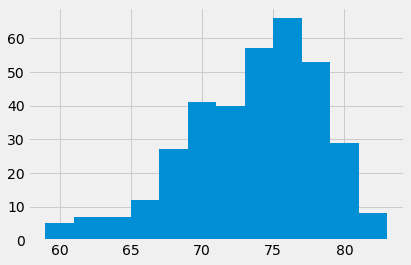

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.date,Measurement.tobs).\
    filter(
        Measurement.date >= func.strftime("%Y-%m-%d",Prev_Recent_Date), 
        Measurement.station == most_active_station_id
    ).\
    order_by(Measurement.date).all()

data_frame = pd.DataFrame(temperature_data, columns=['date', 'tobs'])

hist = data_frame["tobs"].hist(bins=12)

hist

# Close session

In [31]:
# Close Session
session.close()